# Proyecto 2: Prediccion de tiendas Rossman

### Iniciamos cargando las librerias de python y los datos de Rossman

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import scipy.spatial.distance as sc
from sklearn import datasets, linear_model
import sklearn
from sklearn.metrics import (confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,mean_squared_error, r2_score)
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import scipy.optimize as opt
from sklearn import svm
import scipy.stats as st
import warnings

In [11]:
train = pd.read_csv("train.csv",header=0).dropna()
store = pd.read_csv("store.csv",header=0,usecols = [0,1,2]).dropna()

train = train.loc[train.Sales > 0]

data = train.merge(store, on = "Store")

dataa = data.loc[data.StoreType == "a"]

salesa = dataa["Sales"]

customersa = dataa["Customers"]

datad = data.loc[data.StoreType == "d"]

customersd = datad["Customers"]

salesd = datad["Sales"]


/Users/luisontaneda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Utilizamos una función para poder calcular cual es la distribución que describe mejor los datos

In [17]:
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    #Estimamos parametros
    for distribution in DISTRIBUTIONS:

        # aplicamos la funcion fit a los datos
        try:
            
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                params = distribution.fit(data)

                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                
                # Verificamos si le queda mejor la distribucion a los datos
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

# Nodo 1
## Predecir las ventas de las empresas tipo "a" 100 dias adelante

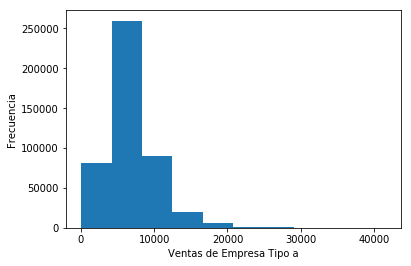

In [47]:
plt.hist(salesa)
plt.xlabel("Ventas de Empresa Tipo a")
plt.ylabel("Frecuencia")

plt.show()


### Utilizamos la función y descubrimos que la distribución que siguen estos datos es la de johnsonsu

In [115]:
best_fit_name, best_fit_paramms = best_fit_distribution(salesa, 200)

In [60]:
best_fit_paramms = st.johnsonsu.fit(salesa)

promsalesa = np.mean(salesa)

minsalesa = min(salesa)

maxsalesa = max(salesa)

### Aqui se puede observar como los valores siguen la distribución

<function matplotlib.pyplot.show>

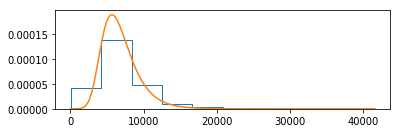

In [61]:
plt.subplot(211)
plt.hist(salesa,normed = True,histtype = "step")
plt.plot(st.johnsonsu(arg[0],arg[1],loc = loc, scale = scale).pdf(np.arange(0,maxsalesa)))
plt.show

### Realizamos random walks

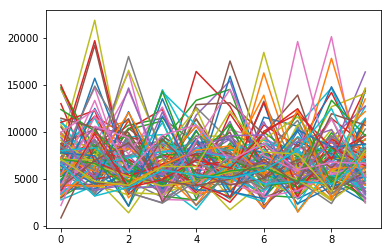

La media es: 6925.697986180701 El minimo es: 46 El maximo es: 41551


In [8]:
arg = best_fit_paramms[:-2]
loc = best_fit_paramms[-2]
scale = best_fit_paramms[-1]


predventas = [st.johnsonsu(arg[0],arg[1],loc = loc, scale = scale).rvs(size = 100) for i in range(10)]
    
plt.plot(predventas)
plt.show()

print("La media es:",promsalesa,"El minimo es:",minsalesa,"El maximo es:",maxsalesa)

In [90]:
kk = [i for j in predventas for i in j]

d_norm, p_norm = st.kstest(kk, st.johnsonsu.cdf(arg[0],arg[1],loc = loc, scale = scale))  # test if the sample_norm is distributed normally (correct hypothesis)
print('Statistic values: %.4f, %.4f' % (d_norm))
print('P-values: %.4f, %.4f' % (p_norm))

TypeError: _parse_args() missing 1 required positional argument: 'b'

### Calculamos la probabilidad de que hayan mas de 8000 ventas

In [113]:
probmas8000 = st.johnsonsu(arg[0],arg[1],loc = loc, scale = scale).cdf(8000)
print("La probabilidad de mas de 8000 es:",probmas8000)

La probabilidad de mas de 8000 es: 0.7095545668204997


### Un escenario para los 100 dias de prediccion seria:

In [97]:
pd.DataFrame(m[0],columns = ["Predicción Ventas"])

,Predicción Ventas
0,2489.904980
1,4115.325890
2,8287.081913
3,12601.530677
4,4858.699916
5,3728.593650
6,8962.915686
7,7263.271430
8,8257.652074
9,2438.009536


# Nodo 2
## Predecir los clientes de las empresas tipo "d" 100 dias adelante

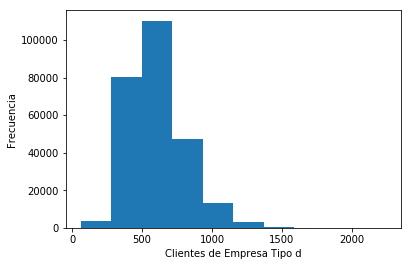

In [88]:
plt.hist(customersd)
plt.xlabel("Clientes de Empresa Tipo d")
plt.ylabel("Frecuencia")
plt.show()

### Se repite lo que hicimos en el nodo anterior solamente cambiando los datos

In [18]:
best_fit_name, best_fir_paramms = best_fit_distribution(customersd, 200)

NameError: name 'customers' is not defined

In [9]:
best_fit_paramms = st.f.fit(customersd)

arg1 = best_fit_paramms[:-2]
loc1 = best_fit_paramms[-2]
scale1 = best_fit_paramms[-1]

promcustomers = np.mean(customersd)

mincustomers = min(customersd)

maxcustomers = max(customersd)

/Users/luisontaneda/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


<function matplotlib.pyplot.show>

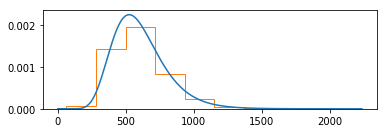

In [70]:
plt.subplot(211)
plt.plot(st.f(arg1[0],arg1[1],loc = loc1, scale=scale1).pdf(np.arange(0,maxcustomers)))
plt.hist(customersd,normed = True,histtype = "step")
plt.show

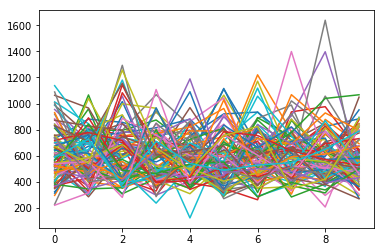

La media es: 606.3539347987387 El minimo es: 64 El maximo es: 2239


In [10]:

predcust = [st.f(arg1[0],arg1[1],loc = loc1, scale=scale1).rvs(size = 100) for i in range(10)]
            
plt.plot(predcust)
plt.show()

prob = st.f(arg1[0],arg1[1],loc = loc1, scale=scale1).cdf(400)
print("La media es:",promcustomers,"El minimo es:",mincustomers,"El maximo es:",maxcustomers)

### Calculamos la probabilidad de que hayan mas de 800 clientes

In [112]:
probmas800 = st.f(arg1[0],arg1[1],loc = loc1, scale=scale1).cdf(800)
print("La probabilidad de mas de 800 es:",probmas800)

La probabilidad de mas de 800 es: 0.8467654601511313


### Un escenario para los 100 dias de prediccion seria:

In [98]:
pd.DataFrame(k[0],columns = ["Predicción Clientes"])

,Predicción Clientes
0,782.269947
1,471.505604
2,473.750583
3,526.308195
4,823.100348
5,515.009884
6,432.412518
7,512.565319
8,772.834302
9,592.653668


# Nodo 3

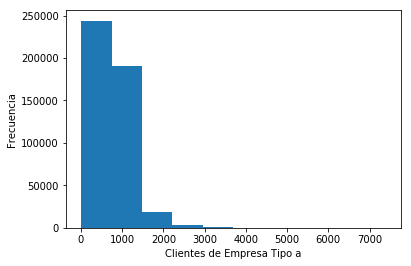

In [21]:
plt.hist(customersa)
plt.xlabel("Clientes de Empresa Tipo a")
plt.ylabel("Frecuencia")

plt.show()



In [19]:
best_fit_name, best_fit_paramms = best_fit_distribution(customersa, 200)

In [91]:
best_fit_paramms = st.mielke.fit(customersa)

promcustomersa = np.mean(customersa)

mincustomersa = min(customersa)

maxcustomersa = max(customersa)

/Users/luisontaneda/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)
/Users/luisontaneda/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


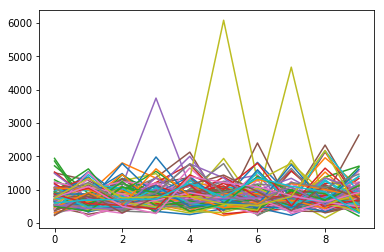

La media es: 795.4223703729635 El minimo es: 8 El maximo es: 7388


In [92]:
arg = best_fit_paramms[:-2]
loc = best_fit_paramms[-2]
scale = best_fit_paramms[-1]


predclientes = [st.mielke(arg[0],arg[1],loc = loc, scale = scale).rvs(size = 100) for i in range(10)]
    
plt.plot(predclientes)
plt.show()

print("La media es:",promcustomersa,"El minimo es:",mincustomersa,"El maximo es:",maxcustomersa)

<function matplotlib.pyplot.show>

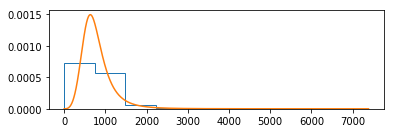

In [93]:
plt.subplot(211)
plt.hist(customersa,normed = True,histtype = "step")
plt.plot(st.mielke(arg[0],arg[1],loc = loc, scale=scale).pdf(np.arange(0,maxcustomersa)))
plt.show

# Nodo 4

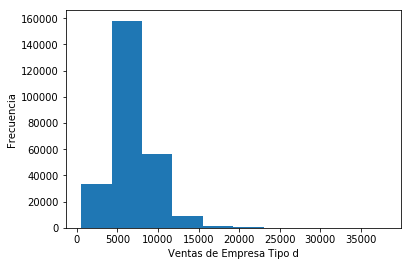

In [22]:
plt.hist(salesd)
plt.xlabel("Ventas de Empresa Tipo d")
plt.ylabel("Frecuencia")

plt.show()


In [23]:
best_fit_name, best_fit_paramms = best_fit_distribution(salesd, 200)

In [94]:
best_fit_paramms = st.johnsonsu.fit(salesd)

promsalesd = np.mean(salesd)

minsalesd = min(salesd)

maxsalesd = max(salesd)

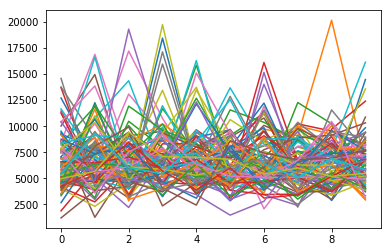

La media es: 6822.300064150127 El minimo es: 538 El maximo es: 38037


In [95]:
arg = best_fit_paramms[:-2]
loc = best_fit_paramms[-2]
scale = best_fit_paramms[-1]


predventas1 = [st.johnsonsu(arg[0],arg[1],loc = loc, scale = scale).rvs(size = 100) for i in range(10)]
    
plt.plot(predventas1)
plt.show()

print("La media es:",promsalesd,"El minimo es:",minsalesd,"El maximo es:",maxsalesd)

<function matplotlib.pyplot.show>

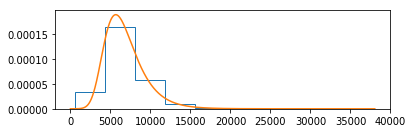

In [96]:
plt.subplot(211)
plt.hist(salesd,normed = True,histtype = "step")
plt.plot(st.johnsonsu(arg[0],arg[1],loc = loc, scale=scale).pdf(np.arange(0,maxsalesd)))
plt.show

# Conclusion

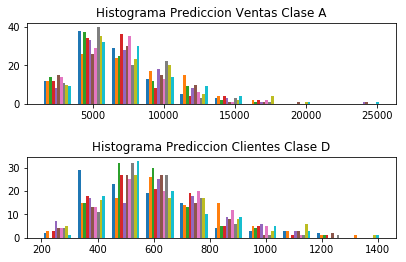

In [38]:
plt.subplot(211)
plt.hist(m)
plt.title("Histograma Prediccion Ventas Clase A")

plt.subplot(212)

plt.hist(k)
plt.title("Histograma Prediccion Clientes Clase D")
plt.tight_layout(pad = 2)

plt.show()

#### Aqui mostramos dos histogramas de los resultados de nuestras predicciones. Como era de esperarse cada uno sigue sus respectivas distribuciones. 

## Las ventas mantendran su mayor densidad entre 4500 y 8000 como se puede apreciar en el primer histograma

## Los clientes mantendran su mayor densidad entre 450 y 650,a excepción del  pico que tiene en 350, como se puede apreciar en el segundo histograma. 